BertViz - Vig

Load mBERT and DistilBERT models

Apply BertViz on both

Get multilingual dataset: Flores

Compare parallel sentences

Look for unique heads/patterns

hypotheses:
- If heads exist that attend to positions like nouns or verbs, they should serve different functions in languages where the sentence structure is different. For example, English is subject -> verb and Tagalog is verb -> subject.
- Later attention heads will demonstrate much more significant patterns as opposed to earlier heads, because earlier layers likely encode general modeling while later layers specialize for different languages. I predict earlier layers will have consistent patterns, regardless of language.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from datasets import load_dataset

In [ ]:
# Login to Hugging Face Hub
from huggingface_hub import login
login()

In [ ]:
# Load mBERT (multilingual BERT)
mb_tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
mb_model = AutoModel.from_pretrained('bert-base-multilingual-cased')

# Load DistilBERT (try multilingual first, fallback to base)
try:
    dist_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
    dist_model = AutoModel.from_pretrained('distilbert-base-multilingual-cased')
except Exception:
    dist_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    dist_model = AutoModel.from_pretrained('distilbert-base-uncased')

print('Loaded mBERT:', mb_model.__class__.__name__)
print('Loaded DistilBERT:', dist_model.__class__.__name__)

In [ ]:
ds_dev = load_dataset("openlanguagedata/flores_plus", split="dev")

In [ ]:
# Convert to pandas DataFrame for easier manipulation
import pandas as pd
df_dev = pd.DataFrame(ds_dev)

In [ ]:
df_dev.head()

In [ ]:
# Grab 10 random samples where iso_639_3 == eng, iso_15924 == Latn, and glotto_code == stan1293
eng_sample = df_dev[(df_dev['iso_639_3'] == 'eng') & 
                    (df_dev['iso_15924'] == 'Latn') & 
                    (df_dev['glottocode'] == 'stan1293')].sample(10, random_state=42)

# Grab 10 random samples where iso_639_3 == fil, iso_15924 == Latn, and glotto_code == fili1244
fil_sample = df_dev[(df_dev['iso_639_3'] == 'fil') & 
                    (df_dev['iso_15924'] == 'Latn') & 
                    (df_dev['glottocode'] == 'fili1244')].sample(10, random_state=42)

In [ ]:
eng_sample

In [ ]:
fil_sample

In [ ]:
# Install bertviz for visualization
!pip install bertviz

In [ ]:
from bertviz import model_view, head_view

In [ ]:
eng_sentence = eng_sample.iloc[3]["text"]
tagalog_sentence = fil_sample.iloc[3]["text"]

In [ ]:
eng_sentence

In [ ]:
tagalog_sentence

In [ ]:
eng_mb_inputs = mb_tokenizer.encode(eng_sentence, return_tensors='pt')
eng_mb_outputs = mb_model(eng_mb_inputs, output_attentions=True)
eng_mb_attention = eng_mb_outputs.attentions
eng_mb_tokens = mb_tokenizer.convert_ids_to_tokens(eng_mb_inputs[0])

In [ ]:
tag_mb_inputs = mb_tokenizer.encode(tagalog_sentence, return_tensors='pt')
tag_mb_outputs = mb_model(tag_mb_inputs, output_attentions=True)
tag_mb_attention = tag_mb_outputs.attentions
tag_mb_tokens = mb_tokenizer.convert_ids_to_tokens(tag_mb_inputs[0])

In [ ]:
eng_dist_inputs = dist_tokenizer.encode(eng_sentence, return_tensors='pt')
eng_dist_outputs = dist_model(eng_dist_inputs, output_attentions=True)
eng_dist_attention = eng_dist_outputs.attentions
eng_dist_tokens = dist_tokenizer.convert_ids_to_tokens(eng_dist_inputs[0])

In [ ]:
tag_dist_inputs = dist_tokenizer.encode(tagalog_sentence, return_tensors='pt')
tag_dist_outputs = dist_model(tag_dist_inputs, output_attentions=True)
tag_dist_attention = tag_dist_outputs.attentions
tag_dist_tokens = dist_tokenizer.convert_ids_to_tokens(tag_dist_inputs[0])

In [ ]:
model_view(eng_mb_attention, eng_mb_tokens, mb_model.config.num_attention_heads)

In [ ]:
head_view(eng_mb_attention, eng_mb_tokens)

In [ ]:
model_view(tag_mb_attention, tag_mb_tokens, mb_model.config.num_attention_heads)

In [ ]:
head_view(tag_mb_attention, tag_mb_tokens)

In [ ]:
model_view(eng_dist_attention, eng_dist_tokens, dist_model.config.num_attention_heads)

In [ ]:
head_view(tag_mb_attention, tag_mb_tokens)

In [ ]:
model_view(tag_dist_attention, tag_dist_tokens, dist_model.config.num_attention_heads)

In [ ]:
head_view(tag_mb_attention, tag_mb_tokens)

# part 2

Hypotheses:

- How do attention activation clusters vary with English vs Tagalog text? I would predict that the clusters would look dramatically different

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import os
import string
from scipy.spatial.distance import jensenshannon

class MBERTAnalyzer:
    """
    A class to analyze attention patterns in Multilingual BERT (mBERT).
    Includes heatmaps, layer trends, and cross-lingual consistency metrics.
    Adapted from https://github.com/clarkkev/attention-analysis.git - the original
    Git repo for the "What Does BERT Look At?" paper.
    """
    def __init__(self, model_name="bert-base-multilingual-cased"):
        print(f"Loading {model_name}...")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name, output_attentions=True)
        self.model.to(self.device)
        self.model.eval()

    def get_attention(self, text):
        """Extracts attention weights and tokens for a given string."""
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # attentions shape: (num_layers, batch, num_heads, seq_len, seq_len)
        attentions = torch.stack(outputs.attentions).squeeze(1).cpu().numpy()
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        return attentions, tokens

    def calculate_token_attention(self, attentions, tokens, target_token):
        """Calculates mean attention paid to a specific token (e.g., '[SEP]' or '[CLS]')."""
        try:
            target_idx = tokens.index(target_token)
        except ValueError:
            return None
        return attentions[:, :, :, target_idx].mean(axis=-1)

    def calculate_punct_attention(self, attentions, tokens):
        """Calculates mean attention paid to punctuation marks."""
        punct_indices = [i for i, t in enumerate(tokens) if t in string.punctuation]
        if not punct_indices:
            return np.zeros((attentions.shape[0], attentions.shape[1]))
        return attentions[:, :, :, punct_indices].sum(axis=-1).mean(axis=-1)

    def calculate_avg_distance(self, attentions):
        """Calculates the weighted average distance of attention per head."""
        layers, heads, seq_len, _ = attentions.shape
        dist_matrix = np.abs(np.arange(seq_len)[:, None] - np.arange(seq_len)[None, :])

        avg_distances = np.zeros((layers, heads))
        for l in range(layers):
            for h in range(heads):
                avg_distances[l, h] = np.sum(attentions[l, h] * dist_matrix) / seq_len
        return avg_distances

    def calculate_cross_lingual_consistency(self, atts1, atts2):
        """
        Measures the similarity (1 - JS Divergence) between two attention maps.
        Higher value means the model uses a more similar attention strategy across inputs.
        Note: We mean-pool across the sequence length to compare head signatures.
        JS Divergence is a smoothed and symmetrical version of KL Divergence.
        A low divergence score (close to 1 on the graph) indicates a language-agnostic
        attention strategy.
        """
        layers, heads, seq1, _ = atts1.shape
        _, _, seq2, _ = atts2.shape

        # Aggregate attention distributions per head (mean distribution across tokens)
        dist1 = atts1.mean(axis=2) # [layer, head, to_token]
        dist2 = atts2.mean(axis=2) # [layer, head, to_token]

        consistency = np.zeros((layers, heads))
        for l in range(layers):
            for h in range(heads):
                # We compare the 'entropy signature' of the head.
                # Since seq lengths differ, we compare the mean attention weight variance
                # or simplified: the JS divergence of sorted distributions.
                p = np.sort(dist1[l, h])[::-1]
                q = np.sort(dist2[l, h])[::-1]

                # Interpolate to match sizes for comparison
                q_interp = np.interp(np.linspace(0, 1, len(p)), np.linspace(0, 1, len(q)), q)

                # Consistency = 1 - JSD (0 is identical, 1 is completely different)
                consistency[l, h] = 1.0 - jensenshannon(p, q_interp)

        return consistency

    def plot_heatmaps(self, data_dict, title, filename):
        """Generates a grid of heatmaps for multiple languages."""
        n_langs = len(data_dict)
        fig, axes = plt.subplots(1, n_langs, figsize=(5 * n_langs, 5))
        if n_langs == 1: axes = [axes]

        for i, (lang, values) in enumerate(data_dict.items()):
            if values is None: continue
            sns.heatmap(values, ax=axes[i], cmap="YlGnBu", cbar=(i == n_langs - 1))
            axes[i].set_title(f"{lang}")
            axes[i].set_xlabel("Head")
            axes[i].set_ylabel("Layer" if i == 0 else "")

        plt.suptitle(title)
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()

    def plot_layer_trends(self, stats_dict, title, filename, ylabel="Avg Attention"):
        """Generates line graphs showing average metric value per layer."""
        plt.figure(figsize=(10, 6))

        for label, values in stats_dict.items():
            if values is None: continue
            layer_means = values.mean(axis=1)
            plt.plot(range(1, len(layer_means) + 1), layer_means, marker='o', label=label)

        plt.title(title)
        plt.xlabel("Layer")
        plt.ylabel(ylabel)
        plt.xticks(range(1, 13))
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()

In [16]:
analyzer = MBERTAnalyzer()

# Parallel sentences to test interlingua/consistency
samples = {
    "English": "On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.",
    "Spanish": "El lunes, los científicos de la facultad de medicina de la Universidad de Stanford anunciaron el invento de una nueva herramienta de diagnóstico que puede catalogar las células según su tipo: un pequeñísimo chip que se puede imprimir y fabricar con impresoras de inyección de uso corriente, por un posible costo de, aproximadamente, un centavo de dólar por cada uno.",
    "Tagalog": "Noong Lunes, inanunsiyo ng mga siyentipiko mula sa Stanford University School of Medicine ang imbensyon ng panibagong kagamitan sa pag-diagnose na makakauri sa mga cell ayon sa uri: isang maliit na chip na maaaring maprint na maaaring magawa gamit ang standard inkjet na mga printer at posibleng nasa isang U.S. sentimo kada isa."
}

results = {}
print("\nExtracting attentions...")
for lang, text in samples.items():
    results[lang] = analyzer.get_attention(text)

sep_stats = {}
dist_stats = {}
cls_stats = {}
consistency_stats = {}

print("Calculating metrics...")
for lang in samples:
    atts, tokens = results[lang]
    sep_stats[lang] = analyzer.calculate_token_attention(atts, tokens, '[SEP]')
    dist_stats[lang] = analyzer.calculate_avg_distance(atts)
    cls_stats[lang] = analyzer.calculate_token_attention(atts, tokens, '[CLS]')

    # Calculate consistency relative to English (our anchor)
    if lang != "English":
        consistency_stats[f"English-{lang}"] = analyzer.calculate_cross_lingual_consistency(
            results["English"][0], atts
        )

if not os.path.exists("plots"):
    os.makedirs("plots")

# Heatmaps
analyzer.plot_heatmaps(sep_stats, "Attention to [SEP] (By Head)", "plots/heatmap_sep.png")
analyzer.plot_heatmaps(dist_stats, "Avg Attention Distance (By Head)", "plots/heatmap_distance.png")
analyzer.plot_heatmaps(cls_stats, "Attention to [CLS] (By Head)", "plots/heatmap_cls.png")

# Trends
analyzer.plot_layer_trends(sep_stats, "Avg Attention to [SEP] per Layer", "plots/trend_sep.png")
analyzer.plot_layer_trends(dist_stats, "Avg Attention Distance per Layer", "plots/trend_distance.png", ylabel="Avg Distance")
analyzer.plot_layer_trends(cls_stats, "Avg Attention to [CLS] per Layer", "plots/trend_cls.png")

# Language Agnosticism Trend
analyzer.plot_layer_trends(
    consistency_stats,
    "Cross-Lingual Attention Consistency (1 - JSD)",
    "plots/trend_consistency.png",
    ylabel="Consistency Score"
)

print("\nAnalysis complete. View outputs in ./plots")

Loading bert-base-multilingual-cased...

Extracting attentions...
Calculating metrics...

Analysis complete. View outputs in ./plots


Loading model bert-base-multilingual-cased to cuda...

Processing English...
Computing JSD matrix for 144 heads (this may take a moment)...


/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(



Processing Tagalog...
Computing JSD matrix for 144 heads (this may take a moment)...


/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


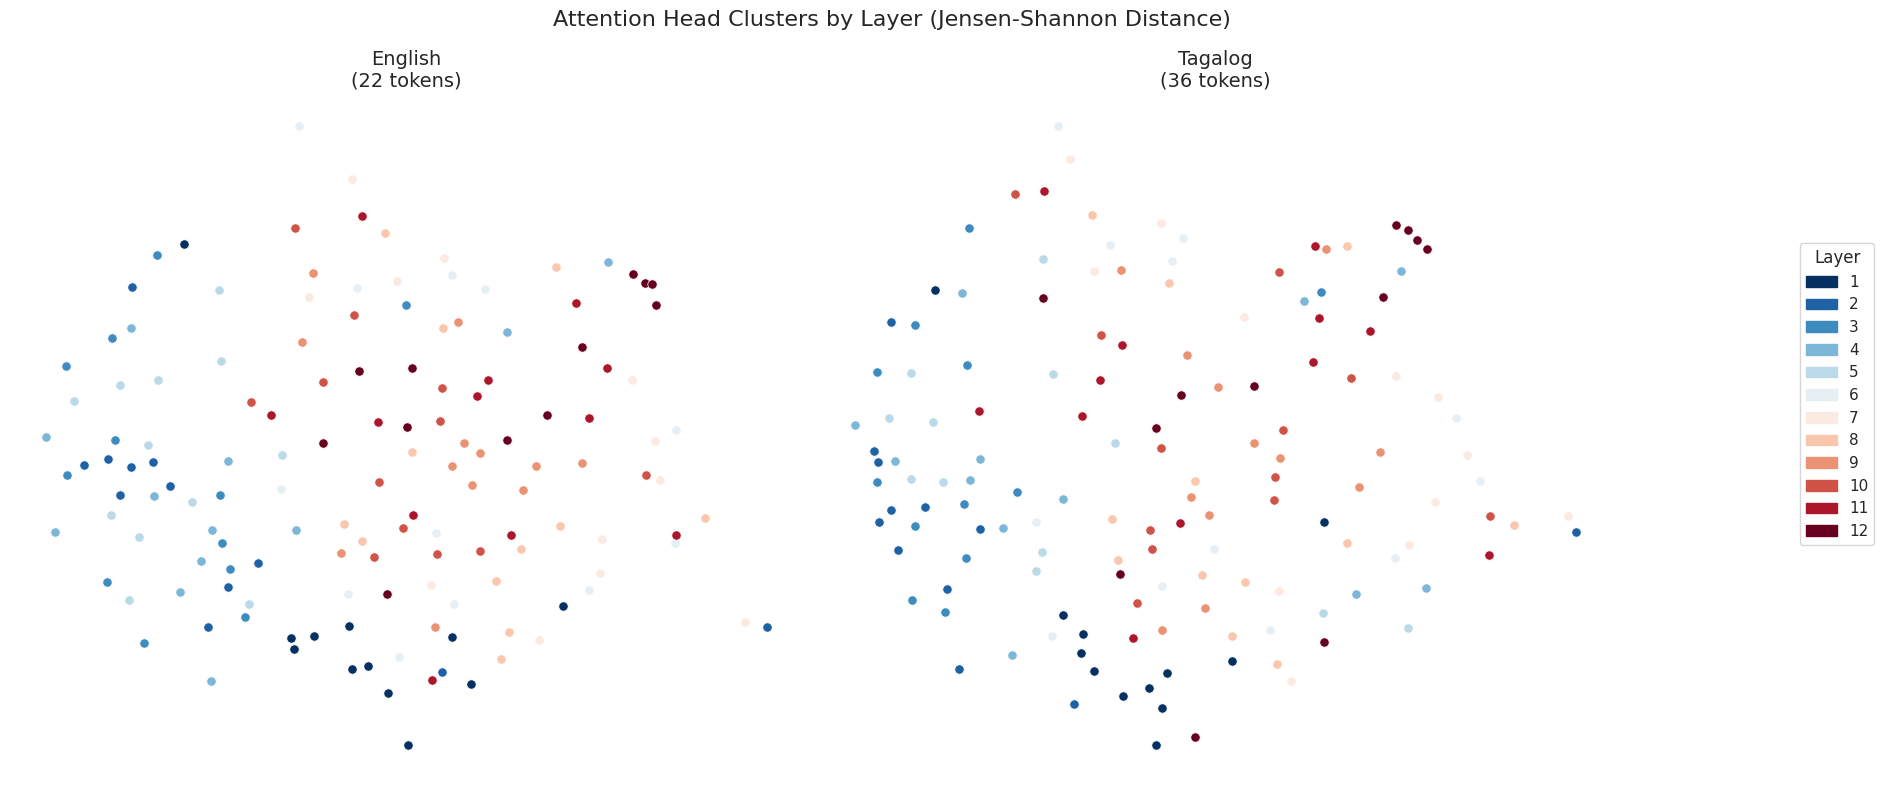

In [26]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import MDS
import seaborn as sns

# Set seaborn style for cleaner plots without gridlines
sns.set_theme(style="white")

class AttentionAnalyzer:
    def __init__(self, model_name="bert-base-multilingual-cased"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading model {model_name} to {self.device}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, output_attentions=True).to(self.device)
        self.model.eval()

    def get_attention(self, text):
        """Extracts attention weights and tokens for a given string."""
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # attentions shape: (num_layers, batch, num_heads, seq_len, seq_len)
        attentions = torch.stack(outputs.attentions).squeeze(1).cpu().numpy()
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        return attentions, tokens

    def compute_head_distances(self, attentions):
        """Computes Jensen-Shannon Distance between all pairs of heads."""
        n_layers, n_heads, seq_len, _ = attentions.shape
        total_heads = n_layers * n_heads
        
        flat_attentions = attentions.reshape(total_heads, seq_len, seq_len)
        distance_matrix = np.zeros((total_heads, total_heads))
        
        print(f"Computing JSD matrix for {total_heads} heads (this may take a moment)...")
        # Optimization: Pre-compute square roots for slightly faster JSD calculation if needed,
        # but standard loop is usually fine for < 200 heads.
        for i in range(total_heads):
            for j in range(i + 1, total_heads):
                P = flat_attentions[i]
                Q = flat_attentions[j]
                # Compute JS distance (sqrt(JSD divergence)) averaging over token positions
                js_distances = jensenshannon(P, Q, axis=1)
                avg_dist = np.mean(js_distances)
                
                distance_matrix[i, j] = avg_dist
                distance_matrix[j, i] = avg_dist
                
        return distance_matrix

    def visualize_clusters(self, text_en, text_tl):
        data_pairs = [("English", text_en), ("Tagalog", text_tl)]
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
        # --- Define Discrete Colors for Layers ---
        # We need exactly 12 distinct colors. 
        # 'RdBu_r' (reversed Red-Blue) goes from deep blue to white to deep red, matching the image well.
        # We sample it into 12 discrete bins.
        cmap = matplotlib.colormaps['RdBu_r'].resampled(12)
        layer_colors = [cmap(i) for i in range(12)]
        
        legend_handles = []

        for idx, (lang, text) in enumerate(data_pairs):
            print(f"\nProcessing {lang}...")
            attentions, tokens = self.get_attention(text)
            n_layers, n_heads = attentions.shape[0], attentions.shape[1]

            # 1. Compute Distances & 2. MDS Projection
            dist_matrix = self.compute_head_distances(attentions)
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=4, max_iter=300)
            coords = mds.fit_transform(dist_matrix)
            
            # 3. Plotting
            ax = axes[idx]
            
            # Iterate through layers to plot distinct colors
            for layer in range(n_layers):
                start_idx = layer * n_heads
                end_idx = start_idx + n_heads
                layer_coords = coords[start_idx:end_idx]
                
                # Assign specific color from our discrete list
                SpecificColor = layer_colors[layer]
                
                ax.scatter(
                    layer_coords[:, 0], 
                    layer_coords[:, 1], 
                    color=SpecificColor,
                    s=45,
                    edgecolor='white', linewidth=0.5 # Add slight border for definition
                )
                
                # Create legend handles only once (during first loop iteration)
                if idx == 0 and layer == 0:
                     for i in range(n_layers):
                         patch = mpatches.Patch(color=layer_colors[i], label=f'{i+1}')
                         legend_handles.append(patch)

            ax.set_title(f"{lang}\n({len(tokens)} tokens)", fontsize=14)
            # Remove ticks and spines for a clean "map" look
            ax.set_xticks([])
            ax.set_yticks([])
            sns.despine(left=True, bottom=True, ax=ax)

        # Add the discrete legend to the right side of the plot
        fig.legend(handles=legend_handles, title="Layer", loc='center right', bbox_to_anchor=(1.05, 0.5), frameon=True)
        
        plt.suptitle("Attention Head Clusters by Layer (Jensen-Shannon Distance)", fontsize=16, y=0.98)
        plt.tight_layout()
        # Adjust layout to make room for the legend on the right
        plt.subplots_adjust(right=0.9) 
        plt.show()

# --- Usage ---
# Using multilingual BERT to ensure shared embedding space for both languages
analyzer = AttentionAnalyzer("bert-base-multilingual-cased")

# Example Sentences (slightly longer to ensure rich attention patterns)
sentence_en = "The agreement was signed yesterday between the two countries after long negotiations regarding trade tariffs."
sentence_tl = "Nilagdaan ang kasunduan kahapon sa pagitan ng dalawang bansa pagkatapos ng mahabang negosasyon tungkol sa taripa sa kalakalan."

analyzer.visualize_clusters(sentence_en, sentence_tl)

Loading bert-base-multilingual-cased...
Processing English...
Processing Tagalog...

Global Structural Correlation (Pearson): 0.8666


/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(
/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/home/jayo/mini

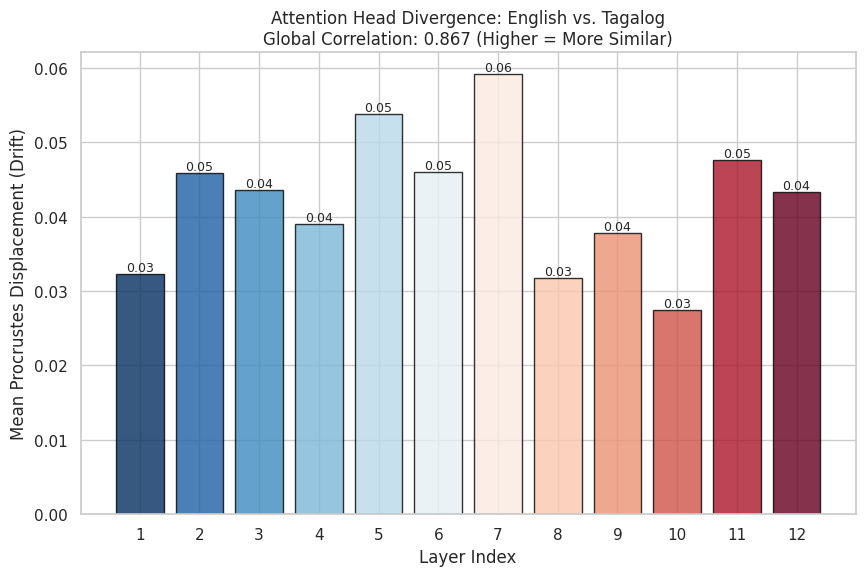

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import jensenshannon
from scipy.spatial import procrustes
from scipy.stats import pearsonr
from sklearn.manifold import MDS
import seaborn as sns

sns.set_theme(style="whitegrid")

class AttentionComparator:
    def __init__(self, model_name="bert-base-multilingual-cased"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, output_attentions=True).to(self.device)
        self.model.eval()

    def get_attention_matrix(self, text):
        """Extracts attention and computes the JSD distance matrix."""
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Shape: (num_layers, num_heads, seq_len, seq_len) -> (total_heads, seq_len, seq_len)
        attentions = torch.stack(outputs.attentions).squeeze(1).cpu().numpy()
        n_layers, n_heads, seq_len, _ = attentions.shape
        total_heads = n_layers * n_heads
        
        flat_attentions = attentions.reshape(total_heads, seq_len, seq_len)
        dist_matrix = np.zeros((total_heads, total_heads))
        
        # Compute JSD Matrix
        for i in range(total_heads):
            for j in range(i + 1, total_heads):
                avg_dist = np.mean(jensenshannon(flat_attentions[i], flat_attentions[j], axis=1))
                dist_matrix[i, j] = avg_dist
                dist_matrix[j, i] = avg_dist
                
        return dist_matrix, n_layers, n_heads

    def compare_languages(self, text_en, text_tl):
        print("Processing English...")
        dist_en, n_layers, n_heads = self.get_attention_matrix(text_en)
        
        print("Processing Tagalog...")
        dist_tl, _, _ = self.get_attention_matrix(text_tl)

        # --- Metric 1: Global Correlation (Mantel Test proxy) ---
        # Flatten the upper triangles of the matrices to compare their structures
        upper_tri_indices = np.triu_indices_from(dist_en, k=1)
        correlation, _ = pearsonr(dist_en[upper_tri_indices], dist_tl[upper_tri_indices])
        print(f"\nGlobal Structural Correlation (Pearson): {correlation:.4f}")

        # --- Metric 2: Layer-wise Procrustes Displacement ---
        # Project both to 2D first
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
        coords_en = mds.fit_transform(dist_en)
        coords_tl = mds.fit_transform(dist_tl)

        # Procrustes Analysis: strictly aligns coords_tl to match coords_en (rotation/scale/translation)
        # standardized_en and standardized_tl are the aligned coordinates
        # disparity is the sum of squared errors
        standardized_en, standardized_tl, disparity = procrustes(coords_en, coords_tl)
        
        # Calculate Euclidean distance between each head's English pos and Tagalog pos
        # Shape: (total_heads,)
        head_drifts = np.linalg.norm(standardized_en - standardized_tl, axis=1)
        
        # Aggregate by layer
        layer_drifts = []
        for i in range(n_layers):
            start = i * n_heads
            end = start + n_heads
            # Average drift for all heads in this layer
            avg_layer_drift = np.mean(head_drifts[start:end])
            layer_drifts.append(avg_layer_drift)

        self.plot_layer_divergence(layer_drifts, correlation)

    def plot_layer_divergence(self, layer_drifts, correlation):
        plt.figure(figsize=(10, 6))
        
        # Create a colormap that matches the previous plot (Blue=Early, Red=Late)
        cmap = matplotlib.colormaps['RdBu_r'].resampled(len(layer_drifts))
        colors = [cmap(i) for i in range(len(layer_drifts))]
        
        layers = range(1, len(layer_drifts) + 1)
        bars = plt.bar(layers, layer_drifts, color=colors, edgecolor='black', alpha=0.8)
        
        plt.xlabel("Layer Index")
        plt.ylabel("Mean Procrustes Displacement (Drift)")
        plt.title(f"Attention Head Divergence: English vs. Tagalog\nGlobal Correlation: {correlation:.3f} (Higher = More Similar)")
        plt.xticks(layers)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center', va='bottom', fontsize=9)

        plt.show()

# --- Usage ---
comparator = AttentionComparator()

text_en = "The agreement was signed yesterday between the two countries after long negotiations."
text_tl = "Nilagdaan ang kasunduan kahapon sa pagitan ng dalawang bansa pagkatapos ng mahabang negosasyon."

comparator.compare_languages(text_en, text_tl)